<a href="https://colab.research.google.com/github/bensenberner/airline-sentiment-prediction/blob/master/notebooks/Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [33]:
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
data_path = 'drive/My Drive/airline-sentiment'
bs=24

# need to set a bunch of random seeds to ensure reproducibility
seed=42
import numpy
numpy.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)

See EDA notebook in [notebooks/Data.ipynb](https://github.com/bensenberner/airline-sentiment-prediction) to learn about how the data was generated.

# Language Model

First, we will train an LSTM encoder-decoder to predict the next word given a sequence of words. fastai will, by default, download a model that is trained to do this on a large corpus of wikipedia pages (wikitext-103), so it already has a "rudimentary understanding of English."

Here, we will fine-tune this model to perform the same task on our training data of airline tweets.
It's likely that there are tokens within the tweets that were absent from wikipedia, particularly #hashtags and @mentions, so the model needs to tweak its embeddings to be able to represent those as well.

When the encoder has been trained to the point that, using only its last hidden state after encoding a tweet, the decoder is able predict the next token of the tweet, we assume that the encoder's representation of language is meaningful. Then, we can use the encoder's tweet representation as input to a classifier to predict the tweet's sentiment instead of the next token.

In [80]:
lm_data = (
    TextList
    .from_csv(data_path, 'filtered_train_text.csv')
    .split_by_rand_pct(0.1, seed=seed)
    .label_for_lm()
    .databunch(bs=bs)
)
lm_data.save('lm_data')

In [2]:
lm_data = load_data(data_path, 'lm_data')

In [81]:
lm_data.show_batch()

idx,text
0,"yesterday . xxmaj confirmed upgrade & & carry on , got to counter & & manager upgraded somebody else on my seat ! xxbos @united we have tried to change our flight xxup three times on the phone and got disconnected each time . xxbos xxmaj decisions xxmaj decisions xxunk @united : xxmaj we 'd love for you to try our service . xxmaj we offer status match too ."
1,"supposed to land 3 hours ago bc i am xxup xxunk tired xxbos @southwestair i 've been on hold for an hour now . xxunk as i type this . xxmaj ridiculous ! xxmaj all i need is the link to the chart that has routes , time xxbos @usairways xxmaj uh yeah . xxmaj flight boarded & & now 1 hr xxmaj late xxmaj flightr we still sit ."
2,"out of xxup jfk , 2 & & 1 / 2 hr delay . i could get over it if it was just weather relate xxmaj flightd , but considering it 's not - xxmaj come on xxbos @americanair xxup finally called me back ... xxup but xxup xxunk xxup spoken xxup to xxup me . xxmaj like the worst xxunk call xxup ever ! ! xxbos @united your airline"
3,"loyal xxmaj workers http : / / t.co / xxunk via xxunk xxbos @jetblue they absolutely guaranteed us we would sit with our kids . xxmaj your "" terms "" response is insulting . # jetblue xxbos @united i think you should board from the back of the plane # xxunk # xxunk xxbos @jetblue yes , today . xxmaj flight is full now . xxmaj they said no to"
4,""" when you xxmaj cancelled xxmaj flighted my flight and made me drive 17 hours to get home .. xxbos @usairways when your routing system goes down which xxunk all your long haul flights you should think about a # xxunk plan xxbos @usairways what is policy on changing flight to different dates once your flight has been delayed ? xxbos @usairways so you do n't have a pilot now"


In [12]:
lm = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.3) # drop_mult taken from fast.ai course v3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


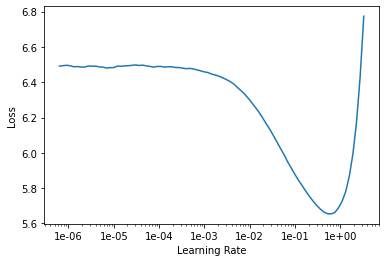

In [5]:
lm.lr_find()
lm.recorder.plot()

Should pick somewhere between 7e-03 and 4e-01. 1e-2 is a nice even number perched near the top of the slope

In [6]:
init_lr = 1e-02

Initially use one cycle, `moms=(0.8, 0.7)` is taken from the fastai text tutorial.
Could be worth tuning this with a hyperparameter grid search method?

In [ ]:
lm.fit_one_cycle(1, init_lr, moms=(0.8, 0.7))
lm.save('1_airline_lm')

Now that I've saved the language model, I can go back and try different values for `cyc_len`.

In [15]:
lm.unfreeze()
lm.fit_one_cycle(9, init_lr * 0.1, moms=(0.8, 0.7))
lm.save('4_airline_lm')
lm.save_encoder('4_airline_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.912562,3.832811,0.275140,00:08
1,3.781224,3.718559,0.285658,00:08
2,3.604027,3.642164,0.294224,00:08
3,3.386906,3.611799,0.300279,00:08
4,3.145127,3.634999,0.298270,00:08
5,2.880538,3.703717,0.294085,00:08
6,2.650578,3.764342,0.292383,00:08
7,2.474779,3.812499,0.291546,00:08
8,2.384050,3.828013,0.290374,00:08


In [18]:
text = "My flight was cancelled due"
n_words = 40
n_sentences = 5
print("\n".join(lm.predict(text, n_words, temperature=0.8) for _ in range(n_sentences)))

My flight was cancelled due to weather , but i would be on another flight to DFW tonight . xxbos @jetblue i 'd like to hear another thing about my flight from ORD but i was not told it was Late
My flight was cancelled due to delays , but what is happening ? Been trying to get home for over an hour and no help xxbos @united You 're on top of that . i will be calling to apologize for the delay
My flight was cancelled due to weather . WTF is happening . Can you help ? There are Cancelled Flights . Either . xxbos @jetblue Thanks for the help ! Just wanted to see where you 're
My flight was cancelled due to delay with US Airways . The same one that booked me on Delta at tomorrow . xxbos @southwestair i would like a refund for my flight that landed 2 days ago . It 's
My flight was cancelled due to your need to change it - it landed in IAD . i 'm not happy with my pay . xxbos @americanair Thanks for the customer service advise . It is much appreciated . xxbos @southwestair and


These seem to capture the frustration of travelers - complaints about poor customer service rep communications, no help, wanting refunds. Some strangeness, but at a cursory glance it looks like normal customer service flight tweets

# Train classifier using airline data only

In [24]:
cls_data = (
    TextList
    .from_csv(data_path, 'filtered_train.csv', cols='text')
    .split_by_rand_pct(0.1, seed=seed)
    .label_from_df(cols=0)
    .databunch(bs=bs)
)
cls_data.save('cls_data_1.pkl')

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @jetblue xxmaj flight 136 departs xxunk xxup am xxmaj finally ! ! ! xxmaj arrived xxup jfk with no xxunk at xxunk xxup pm . xxmaj that 's a long flight . xxup aka xxup bus http : / / t.co / xxunk,negative
xxbos @southwestair xxmaj thx xxmaj xxunk xxmaj agt xxmaj xxunk xxmaj xxunk n xxmaj flight xxmaj xxunk . xxmaj xxunk @ xxup den xxmaj airport . xxmaj held flight 1027 n even saved seat 4 xxmaj bus xxmaj select # xxunk !,positive
xxbos @usairways xxmaj flight 830 xxup clt to xxmaj phl . i was 1st on list . xxmaj someone else got spot . xxmaj rude employee in coach . xxmaj xxunk give xxup id . xxmaj said he was cute red head,negative
xxbos @americanair xxmaj what happens when you combine xxmaj top xxmaj xxunk & & the beauty of xxmaj san xxmaj xxunk de xxmaj xxunk . xxmaj my xxmaj late xxmaj flightst food blog . http : / / t.co / xxunk,neutral


Load the LM encoder, this will be used to create embeddings for the classifier. `drop_mult=0.5` taken from the fast.ai text tutorial

In [ ]:
cls = text_classifier_learner(cls_data, AWD_LSTM, drop_mult=0.5)
cls.load_encoder('4_airline_lm_enc')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


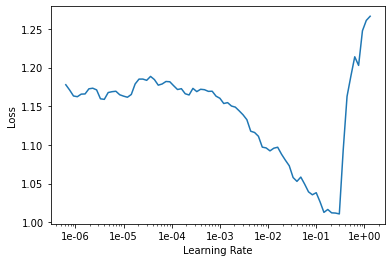

In [27]:
cls.lr_find()
cls.recorder.plot()

A little choppier, I'll use `2e-2` to not risk getting caught in that local min at `1.5e-2`.

In [28]:
init_cls_lr = 2e-02
cls.fit_one_cycle(1, init_cls_lr, moms=(0.8, 0.7))
cls.save('1_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.645560,0.579928,0.760820,00:07


To prevent catastrophic forgetting, we freeze all but the last couple of layers

In [29]:
cls.freeze_to(-2)
# 2.6**4 is a magic number for determining the minimum learning rate. Derived from
# https://course.fast.ai/videos/?lesson=4 @ 33:45
cls.fit_one_cycle(1, slice(init_cls_lr/(2.6**4), init_cls_lr), moms=(0.8,0.7))
cls.save('2_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.656810,0.509612,0.798026,00:09


Following the pattern from the ULMFiT paper, we now decrease the max (and min) learning rates before continuing to train on more unfrozen layers.

In [30]:
cls.freeze_to(-3)
new_cls_lr = init_cls_lr * 0.1
cls.fit_one_cycle(1, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8, 0.7))
cls.save('3_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.550247,0.491732,0.799544,00:13


In [31]:
cls.unfreeze()
cls.fit_one_cycle(5, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8,0.7))
cls.save('4_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.482816,0.464720,0.812453,00:18
1,0.484962,0.444879,0.826879,00:17
2,0.375953,0.449954,0.823842,00:18
3,0.330940,0.477836,0.833713,00:17
4,0.250947,0.474550,0.825361,00:18


After many different runthroughs of different `cyc_len`s for each of these stages (resetting each time), this looks like great validation performance.

In [32]:
cls.export('golden_cls')

In [ ]:
cls.predict("Your customer service is awful, you should be ashamed of yourselves. Never flying again")

(Category tensor(0), tensor(0), tensor([0.9073, 0.0122, 0.0805]))

In [ ]:
cls.predict("Thank you very much for helping me. I'm definitely flying with you again!")

(Category tensor(2), tensor(2), tensor([8.2608e-03, 8.9163e-04, 9.9085e-01]))

In [ ]:
cls.predict("Stuck in line for an hour. I can't believe the customer service")

(Category tensor(0), tensor(0), tensor([0.9547, 0.0298, 0.0155]))

## See [this notebook](https://colab.research.google.com/drive/1P7-Om6yWwzliZUIepo7ftuRrYAkEGeDr) to learn how well this model performed on the test set